In [2]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../common')
import sampling_misc as sampling
sys.path.append('../aho_merging')
import signature_size_model as ssm

# Trying to Find Expectation Using Markov Chain

Before getting into multibranching process theory it might not be too bad to just compute the expected value with the knowledge we know about signatures. Let $Z_n$ be the number of states at depth $n$. Then we can formulate the following.

$$
Z_{n + 1} = \sum_{\lambda \in \Lambda_n} Y_{\lambda, n} - X_{n + 1}
$$

Where $\Lambda_n$ is the set of signatures in depth $n$, $Y_{\lambda, n}$ is the number of offspring for the state with signature $\lambda$ in depth $n$, and $X_{n + 1}$ is the number of states with different parents were merged in depth $n + 1$. I reformed this expression in order to try to compute the expected value.

$$
Z_{n + 1} = \sum_{\lambda \in \Lambda_n} \sum_{\hat{\lambda}} Y_{\hat{\lambda}, n} \mathbb{1}(\lambda = \hat{\lambda}) - X_{n + 1}
$$

If we assume that $Y_{\hat{\lambda}, n}$ and $\mathbb{1}(\lambda = \hat{\lambda})$ are independent (and I feel like they should be, why would choosing the correct signature affect the children that signature will have, seems unrelated).

$$
E[Z_{n + 1}] = \sum_{\lambda \in \Lambda_n} \sum_{\hat{\lambda}} E[Y_{\lambda, n} | \hat{\lambda} = \lambda] P(\lambda = \hat{\lambda}) - E[X_{n + 1}]
$$

There is a bit of a problem with this since the first sum has a random variable in it, $\Lambda_n$. I feel that instead we can have this multiplied by $E[Z_n]$ and find $P(\lambda = \hat{\lambda})$ for a general $\lambda$. The specifics of this are still unclear though.

$$
E[Z_{n + 1}] = E[Z_n] \sum_{\hat{\lambda}} E[Y_{\lambda, n} | \hat{\lambda} = \lambda] P(\hat{\lambda}) - E[X_{n + 1}]
$$

$$
E[Z_{n + 1}] = E[Z_n] * E[E[Y_{\lambda, n} | \hat{\lambda} = \lambda]] - E[X_{n + 1}]
$$

# Finding $P(\hat{\lambda})$ via Markov Chain

First note that we really only care about the cardinality of the signatures for computation, so want to find probabilities that revolve around this. To find this probability we can try to use a Markov chain where states are labelled from 1 to $n$ and represent the size of the signature. If we are at state $k$, we transition out of $k$ according to $Binom(k + 1, c_2) + 1$. i.e. we can go to any previous state or we can go to the next state. This makes sense because for each depth in the signature we can either have that depth plus one in the child, or that depth is removed. Also 1 can appear in the child's signature, hence $k + 1$.

By doing this we are assuming a lot about independence. In reality, there is overlap in the suffixes matching the prefixes and the problem is much harder than just matching between two letters ($c_2$). However, this should provide an upper bound because simplifying the problem we are alleviating conditions that sets must have. 

The transition for the MC has a lot of structure and I worked on coming up with an expression that would give the stationary distribution. However, I thought I should test things out in the model and try to nail other details down before I pursued that further. Below I tested the Markov Chain and compared it with the simulation. As expected it is an upper bound and is pretty tight.

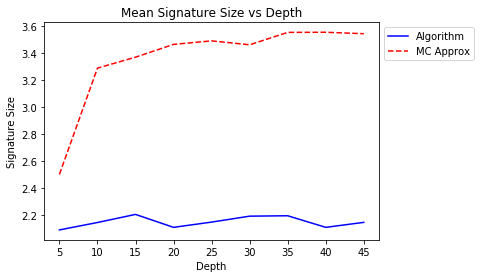

In [5]:
# Compare distributions of signature size at depth k for actual algorithm and Markov Chain (hopeful upper bound).
SIMS = 1000
DEPTHS = range(5, 50, 5)
PROBS = [0.5 for _ in range(4)]

# Draw the samples.
mc_sims = []
alg_sims = []
for depth in DEPTHS:
    mc_avg = 0
    for _ in xrange(SIMS):
        mc_avg += ssm.signature_mc_sim(PROBS, depth)
    mc_sims.append(mc_avg / SIMS)
    alg_samples = sampling.sample_signature_size(SIMS, PROBS, depth)
    alg_sims.append(sum(alg_samples) / SIMS)
    
# Plot the results.
plt.plot(DEPTHS, alg_sims, '-b', label='Algorithm')
plt.plot(DEPTHS, mc_sims, '--r', label='MC Approx')
plt.xlabel('Depth')
plt.ylabel('Signature Size')
plt.title('Mean Signature Size vs Depth')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()

# Finding $E[Y]$

I next tried to find the expected amount of offspring. I came up with the following expression by considering the case where we have all $a$ children but then try to find how many are merged. I think that...

$$
E[Y_\lambda] \geq a -  \sum_{\sigma_1, \sigma_2} \prod_{j \in \lambda} \left[P(\sigma_1 \in G[j + 1], \sigma_2 \in G[j + 1]) + P(\sigma_1 \notin G[j + 1], \sigma_2 \notin G[j + 1])\right]
$$

$$
E[Y_\lambda] \geq a - \sum_{\sigma_1, \sigma_2} \prod_{j \in \lambda} \left[\frac{p_{\sigma_1} p_{\sigma_2}}{(1 - \prod_\hat{\sigma} (1 - p_\hat{\sigma}))^2} + \left(1 - \frac{p_{\sigma_1}}{(1 - \prod_\hat{\sigma} (1 - p_\hat{\sigma})}\right) \left(1 - \frac{p_{\sigma_2}}{(1 - \prod_\hat{\sigma} (1 - p_\hat{\sigma})}\right) \right]
$$

This is a lower bound because we are considering pairs and could over count the much we should subtract. Instead we can consider just one $\sigma$ and compare against all others and then divide by two (since we could double count) to get an upper bound. Assuming that there is uniform probabilities.

$$
E[Y_\lambda] \leq a - \frac{a}{2}  \left(1 - (1 - p_\sigma)^2 \right)^{- 2 \lambda} \left[p_\sigma^2 + (1 - (1 - p\sigma)^a - p_\sigma)^2\right]^\lambda
$$

Trying this above with the MC this turns out to be really bad. Either there is a misconception or I should just be trying something else.

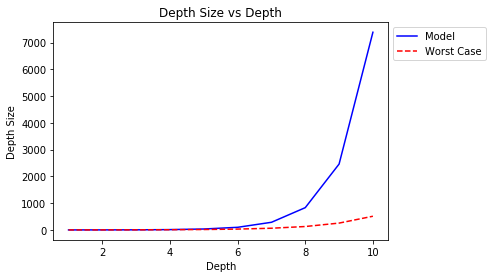

In [3]:
# See what the trend of the system looks like with combination of the MC simulation.

# Start with uniform probabilities, the code below assumes this.
P = 0.5
PROBS = [P for _ in range(4)]
MAX_DEPTH = 10

model_sizes = [1]
for depth in xrange(MAX_DEPTH - 1):
    total_children = 0
    # Iterate over the parents to predict the number of their children.
    for _ in xrange(int(np.ceil(model_sizes[-1]))):
        # Start off assuming that there is no merging.
        new_children = len(PROBS)
        sig_size = ssm.signature_mc_sim(PROBS, depth)
        new_children *= (1 - 0.5 * (1 - (1 - P) ** 2) ** (-2 * sig_size)
                         * (P ** 2 + (1 - (1 - P) ** len(PROBS) - P) ** 2) ** sig_size)
        total_children += new_children
    model_sizes.append(total_children)

worst_case = [1]
for _ in xrange(MAX_DEPTH - 1):
    worst_case.append(2 * worst_case[-1])

depths = range(1, MAX_DEPTH + 1)
plt.plot(depths, model_sizes, '-b', label='Model')
plt.plot(depths, worst_case, '--r', label='Worst Case')
plt.xlabel('Depth')
plt.ylabel('Depth Size')
plt.title('Depth Size vs Depth')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()       

Oof super bad, should probably just re-evaluate this whole model.